# Test suit - 1
* Supplementaty material to the work ``An accurate numerical method for the computation of a class of generalized cosine integrals`` submitted to CNMAC 2024.
* Authors: Guilherme F. Fornel, Fabio S. de Azevedo, Matheus C. Santos, and Esequia Sauter.
 
* In this notebook, we illustrate the usage of the implementation and present comparisons of the results produced by our routine with values obtained by directed integration with multiple precision aritmethics, and those calculated my Maplesoft 15.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ctypes
 
libgcikpi = ctypes.CDLL('../../build/libgcikpi.so')
libgcikpi.gzed_cosine_integral_pi_coef.restype = ctypes.c_double
libgcikpi.gzed_cosine_integral_pi_coef.argtypes = [ctypes.c_uint, ctypes.c_double, ctypes.c_double]
# The function 'gzed_cosine_integral_pi_coef()' has the following signature:
# double gzed_cosine_integral_pi_coef(unsigned int k, double alpha, double deltax)

In [2]:
def ULPs(control, approx):
    """
    Calculate the number of ULPs between two floating point numbers.

    Parameters
    ----------
    control : float in higher precision
        The precise value.
    approx : float in current precision
        The approximate value.

    Returns
    -------
    ulp : float
        The number of ULPs between the two values.
    """
    
    target = type(control)(approx)
    
    abs_control = abs(control)
    abs_target = type(approx)(abs_control)
    eps = type(control)(np.nextafter(abs_target, abs_target + 1) - abs_target)
    ulp = type(approx)((target - control)/eps)
    return ulp

In [3]:
def compare_maple(k):
    error_in_ULPs = []
    values = []
    with open(f"maple_comparison/Ikmaple_{k:03d}.dat") as f:
        for line in f.readlines():
            # Parse values from file
            alpha, mu_control_str = line.split(',')
            alpha_float = float(alpha)
            # Convert mu_control to np.float128
            mu_control = np.float128(mu_control_str[:30])
            # Calculate mu_test
            mu_test = libgcikpi.gzed_cosine_integral_pi_coef(k, alpha_float, 1.0)
            # Calculate error in ULPs
            error = ULPs(mu_control, mu_test)
            error_in_ULPs.append(error)
            values.append(alpha_float)
    return np.array(values), np.array(error_in_ULPs)

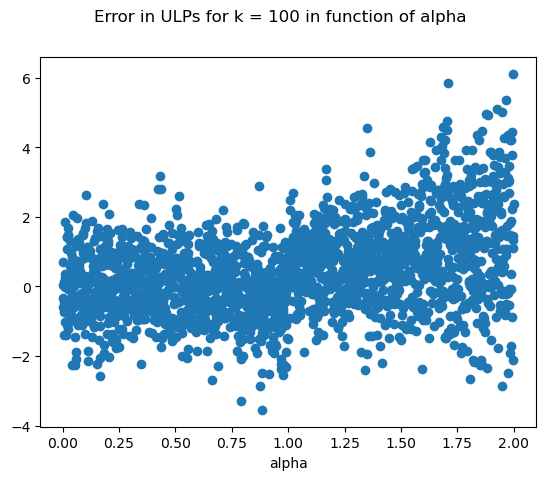

In [4]:
# Plot the error in ULPs for a given k value
k = 100
alpha, ulp = compare_maple(k)
plt.plot(alpha, ulp, 'o')
plt.suptitle(f'Error in ULPs for k = {k} in function of alpha')
plt.xlabel('alpha')
plt.show()

In [5]:
# Compare the error in ULPs for all k values between 1 and 100
ulps = np.zeros((99, len(alpha)))
for k in range(0, 99):
    alpha, ulp = compare_maple(k+1)
    ulps[k] = ulp

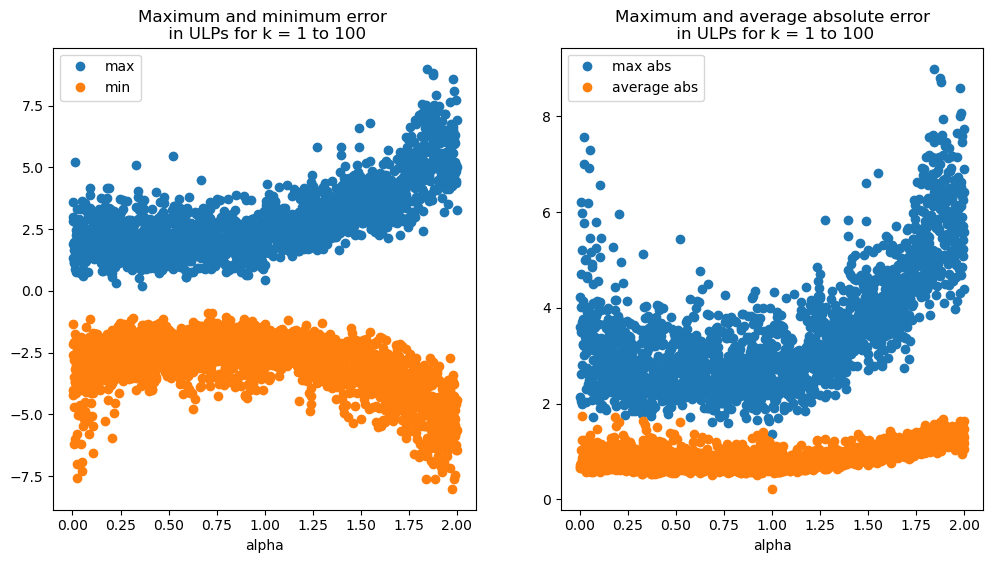

In [6]:
# Plot the maximum and minimum error in ULPs for all k values
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(alpha, ulps.max(axis=0), 'o', label='max')
ax[0].plot(alpha, ulps.min(axis=0), 'o', label='min')
ax[0].set_title('Maximum and minimum error \n in ULPs for k = 1 to 100')
ax[0].legend()
ax[0].set_xlabel('alpha')

ax[1].plot(alpha, np.abs(ulps).max(axis=0), 'o', label='max abs')
ax[1].plot(alpha, np.abs(ulps).mean(axis=0), 'o', label='average abs')
ax[1].set_title('Maximum and average absolute error\n in ULPs for k = 1 to 100')
ax[1].legend()
ax[1].set_xlabel('alpha')
plt.show()